# VAE: Sprites Latent 2D

## 데이터 다운로드

In [1]:
!gdown 1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ

Downloading...
From: https://drive.google.com/uc?id=1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ
To: /content/sprites_1788_16x16.npy
100% 68.7M/68.7M [00:01<00:00, 37.4MB/s]


In [42]:
# 미리 학습한 파라미터 다운
!gdown 1XXDunPNMlxZ_EO6rxAYDHgKsw3SR1XQf

Downloading...
From: https://drive.google.com/uc?id=1XXDunPNMlxZ_EO6rxAYDHgKsw3SR1XQf
To: /content/best_vae.pt
100% 31.6k/31.6k [00:00<00:00, 85.3MB/s]


## 패키지 임포트 & 기타 설정값 세팅

In [2]:
# import the necessary packages
import os, random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm

In [3]:
sprites = np.load('sprites_1788_16x16.npy')

In [4]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

DEVICE

'cuda'

In [5]:
# define model hyperparameters
IMAGE_SIZE = 16
CHANNELS = 3
EMBEDDING_DIM = 5

## 모델링

In [7]:
# def loss_function(VAELossParams, kld_weight):
#     recons, input, mu, log_var = VAELossParams
#     recons_loss = F.mse_loss(recons, input)

#     kld_loss = torch.mean(
#         -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=(1,2,3)), dim=0
#     )

#     loss = recons_loss + kld_weight * kld_loss

#     return {
#         "loss": loss,
#         "recon_loss": recons_loss.detach(),
#         "kld": kld_loss.detach(),
#     }

def loss_function(VAELossParams, kld_weight):
    recons, input, mu, log_var = VAELossParams

    # 이미지가 얼마나 잘 복원되었는지에 대한 MSE 로스
    recons_loss = F.mse_loss(recons, input)

    # latent_dim으로 합하고, 샘플에 대해서 평균
    # 마지막 특징이 (N, C, H, W) 이기 때문에 sum할때 axis=1,2,3에 다 합해야 함
    kld_loss = torch.mean(
        -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=(1,2,3)), dim=0
    )

    loss = recons_loss + kld_weight * kld_loss

    return {
        "loss": loss,
        "Reconstruction_Loss": recons_loss.detach(),
        "KLD": kld_loss.detach(),
    }

In [8]:
# define a convolutional block for the encoder part of the vae
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        # 기본적으로 크기를 반으로 줄임
        super().__init__()

        # sequential block consisting of a 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels,  # number of input channels
                out_channels=out_channels,  # number of output channels
                kernel_size=kernel_size,  # size of the convolutional kernel
                stride=stride,  # stride of the convolution
                padding=padding,  # padding added to the input
            ),
            torch.nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            torch.nn.LeakyReLU(),  # apply leaky relu activation
        )

    def forward(self, x):
        # pass the input through the sequential block
        return self.block(x)

In [9]:
# define a transposed convolutional block for the decoder part of the vae
class ConvTBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
        # 기본적으로 크기를 두배로 늘림
        super().__init__()

        # sequential block consisting of a transposed 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels,  # number of input channels
                out_channels,  # number of output channels
                kernel_size=kernel_size,  # size of the convolutional kernel
                stride=stride,  # stride of the convolution
                padding=padding,  # padding added to the input
                output_padding=output_padding,  # additional padding added to the output
            ),
            torch.nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            torch.nn.LeakyReLU(),  # apply leaky relu activation
        )

    def forward(self, x):
        return self.block(x)  # pass the input through the sequential block

In [10]:
# define the main vae class
class VAE(torch.nn.Module):
    """
    image          encoder        latent        decoder       final layer
    (3, 16, 16) -> (16, 8, 8) -> (5, 8, 8) -> (16, 16, 16) -> (16, 16, 16) -> (3, 16, 16)
    """
    def __init__(self, in_channels, latent_dim, hidden_dims = None):
        super().__init__()

        self.latent_dim = latent_dim  # dimensionality of the latent space
        if hidden_dims is None:
            hidden_dims = [16, ]  # default hidden dimensions
            # img size     8

        self.hidden_dims = hidden_dims[:]
        # self.feature_map_hw = int(IMAGE_SIZE / 2**len(hidden_dims))

        self.encoder = torch.nn.Sequential(
            # (3,16,16)->(16,8,8)
            ConvBlock(in_channels, hidden_dims[0]),
            # hidden_dims에 추가 레이어가 있으면
            # ConvBlock(hidden_dims[0], hidden_dims[1]),
            # ConvBlock(hidden_dims[1], hidden_dims[2]), ... 식으로 추가해주기
        )

        # layer for the mean of the latent space
        self.conv_mu = torch.nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)

        # layer for the variance of the latent space
        self.conv_var = torch.nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)


        self.decoder = torch.nn.Sequential(
            ConvTBlock(latent_dim, hidden_dims[-1]),
            # hidden_dims에 추가 레이어가 있으면
            # ConvBlock(hidden_dims[-1], hidden_dims[-2]),
            # ConvBlock(hidden_dims[-2], hidden_dims[-3]), ... 식으로 추가해주기
        )

        # final layer to reconstruct the original input
        self.final_layer = torch.nn.Sequential(
            torch.nn.Conv2d(
                hidden_dims[-1], hidden_dims[-1],
                kernel_size=3, stride=1, padding=1
            ),

            # normalize the activations of the layer
            torch.nn.BatchNorm2d(hidden_dims[-1]),

            # apply leaky relu activation
            torch.nn.LeakyReLU(),

            # final convolution to match the output channels
            torch.nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, stride=1, padding=1),
        )

    # encoding function to map the input to the latent space
    def encode(self, input):
        # pass the input through the encoder
        result = self.encoder(input) # (N,3,16,16)->(N,16,8,8)

        # compute the mean of the latent space
        mu = self.conv_mu(result) # (N,16,8,8)->(N,5,8,8)

        # compute the log variance of the latent space
        log_var = self.conv_var(result) # (N,16,8,8)->(N,5,8,8)

        return [mu, log_var]

        # decoding function to map the latent space to the reconstructed input
    def decode(self, z):
        # pass the result through the decoder
        result = self.decoder(z) # (N,5,8,8) -> (N,16,16,16)

        # pass the result through the final layer
        result = self.final_layer(result) # (N, 16, 16, 16)->(N, 16, 16, 16)->(N, 3, 16, 16)
        return result

        # reparameterization trick to sample from the latent space
    def reparameterize(self, mu, logvar):
        # compute the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        # sample random noise
        eps = torch.randn_like(std)
        # compute the sample from the latent space
        return eps * std + mu

    # forward pass of the vae
    def forward(self, input):
        # encode the input to the latent space
        mu, log_var = self.encode(input) # (N, 3, 16, 16) -> [(N, 5, 8, 8), (N, 5, 8, 8)]
        #print(mu.shape, log_var.shape)

        # sample from the latent space
        z = self.reparameterize(mu, log_var) # (N, 5, 8, 8)

        # decode the sample, and return the reconstruction
        # along with the original input, mean, and log variance
        recon_input = self.decode(z) # (N, 5, 8, 8) -> (N, 3, 16, 16)

        return [recon_input, input, mu, log_var]

In [11]:
# create output directory
output_dir = "output"
os.makedirs("output", exist_ok=True)

# create the training_progress directory inside the output directory
# training_progress_dir = os.path.join(output_dir, "training_progress")
# os.makedirs(training_progress_dir, exist_ok=True)

# create the model_weights directory inside the output directory
# for storing autoencoder weights
model_weights_dir = os.path.join(output_dir, f"model_weights_latent2D_{EMBEDDING_DIM}")
os.makedirs(model_weights_dir, exist_ok=True)

# define model_weights path including best weighs
MODEL_BEST_WEIGHTS_PATH = os.path.join(model_weights_dir, "best_vae.pt")
MODEL_WEIGHTS_PATH = os.path.join(model_weights_dir, "vae.pt")

In [43]:
# 미리 다운 받은 best_vae_celeba_2d.pt 파일이 있으면 model_weights_dir 밑으로 이동
import shutil

if os.path.exists("./best_vae.pt"):
    shutil.move("./best_vae.pt", MODEL_BEST_WEIGHTS_PATH)

### 이미지 오그먼테이션 설정

In [12]:
# Define the transformations
train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.CenterCrop(148),
        # transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)
valid_transforms = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(148),
        # transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

### 데이터 셋과 데이터 로더

In [13]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        x_0 = self.data[i]

        if self.transform:
            x_0 = self.transform(x_0)

        return x_0

In [14]:
sprites.shape

(89400, 16, 16, 3)

In [15]:
seed = 100

# 전역 난수 생성기 시드 설정
def set_seed(seed_value=42):
    random.seed(seed_value)  # Python의 random 모듈
    np.random.seed(seed_value)  # Numpy 모듈
    torch.manual_seed(seed_value)  # PyTorch를 위한 시드 설정
    torch.cuda.manual_seed_all(seed_value)  # 모든 GPU에 대한 PyTorch 시드 설정
    # torch.backends.cudnn.deterministic = True  # CUDNN을 결정적으로 설정 (속도는 느려질 수 있음)
    # torch.backends.cudnn.benchmark = False  # CUDNN 벤치마크를 끔 (속도는 느려질 수 있음)

set_seed(seed)  # 시드 값을 설정합니다.

# 시드가 고정된 난수 생성기를 생성
g = torch.Generator()
g.manual_seed(seed)
# 데이터셋 분할 시 난수 생성기 전달
train_dataset, valid_dataset = random_split(
    sprites, [80000, 9400], generator=g)

train_ds = MyDataset(np.array(train_dataset), train_transforms)
valid_ds = MyDataset(np.array(valid_dataset), valid_transforms)

print(type(train_dataset))

<class 'torch.utils.data.dataset.Subset'>


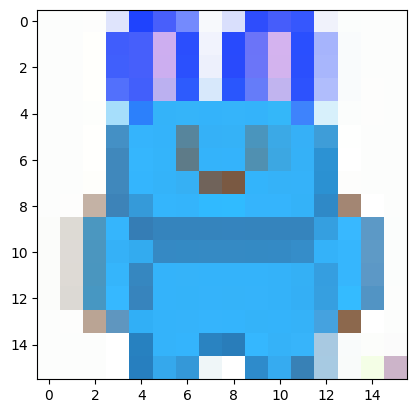

In [16]:
# train 샘플 확인
plt.imshow(train_ds[0].permute(1,2,0))
plt.show()

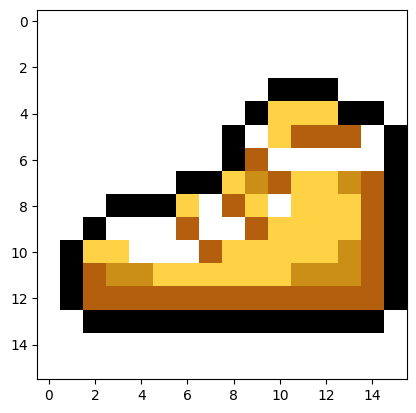

In [17]:
# valid 샘플 확인
plt.imshow(valid_ds[0].permute(1,2,0))
plt.show()

## 실험

### 데이터로더 및 모델 생성

In [18]:
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
train_loader_iter = iter(train_loader)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

In [44]:
EPOCHS = 30
KLD_WEIGHT = 0.00003 # 0.00025
learning_rate = 0.0002
scheduler_gamma = 0.9

model = VAE(CHANNELS, EMBEDDING_DIM)

### 옵티마이저 세팅

- Adam 옵티마이저 사용

- 학습률 스케쥴러를 세팅
    - 레퍼런스: https://panggu15.github.io/etc/pytorch-learning-rate-Scheduler/


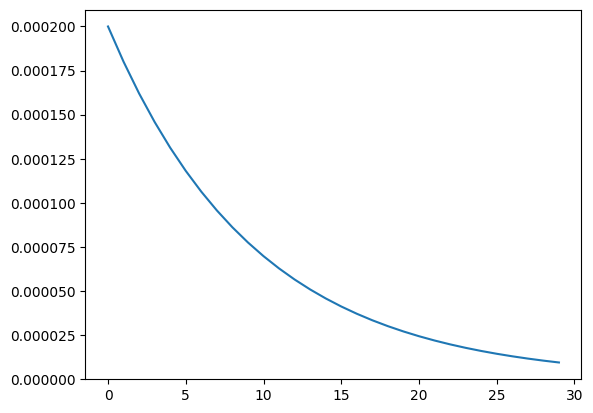

0.0002

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

# lr_scheduler 실험
lrs = []
for i in range(EPOCHS):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(EPOCHS),lrs)
plt.show()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
optimizer.param_groups[0]['lr']

### 포워드 테스트

x_test:  torch.Size([5, 3, 16, 16])
reconstruction:  torch.Size([5, 3, 16, 16])


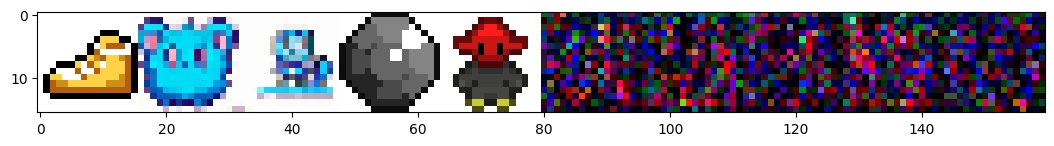

In [45]:
val_loader_iter = iter(valid_loader)

# 샘플 5개 가져오기
x_test = next(val_loader_iter)[:5].clone() #.to(DEVICE)
print('x_test: ', x_test.shape)

# 예측
predictions = model(x_test)
print('reconstruction: ', predictions[0].shape)

fig = plt.figure(figsize=(13,5))
plt.imshow(torch.cat([x_test, predictions[0]]).permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

### 검증 로스 계산 함수

- 학습 중에 이 함수를 사용해서 검증 데이터 에 대한 로스를 계산

In [36]:
def validate(model, val_dataloader, DEVICE):
    running_loss = 0.0

    model.eval()

    with torch.no_grad():
        for i, x in enumerate(val_dataloader):
            x = x.to(DEVICE)
            predictions = model(x)
            total_loss = loss_function(predictions, KLD_WEIGHT)
            running_loss += total_loss["loss"].item()

    return running_loss / len(val_dataloader)

## 학습

Training Started!!


100%|██████████| 2500/2500 [00:24<00:00, 100.75it/s]


Epoch 1/30, Batch 2500/2500, Total Loss: 0.0300, Reconstruction Loss: 0.0182, KL Divergence Loss: 393.9639 Val Loss: 0.0286


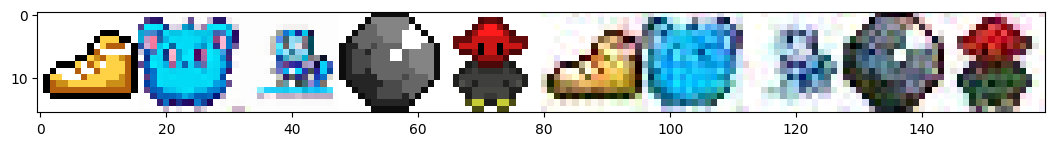

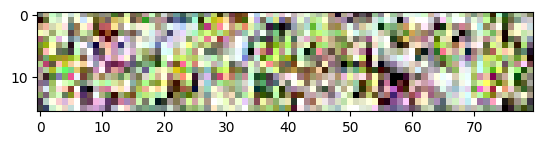

100%|██████████| 2500/2500 [00:24<00:00, 101.78it/s]


Epoch 2/30, Batch 2500/2500, Total Loss: 0.0259, Reconstruction Loss: 0.0149, KL Divergence Loss: 366.9600 Val Loss: 0.0238


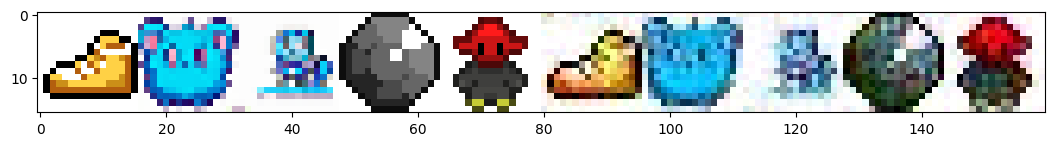

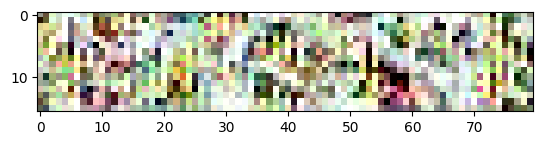

100%|██████████| 2500/2500 [00:24<00:00, 101.68it/s]


Epoch 3/30, Batch 2500/2500, Total Loss: 0.0236, Reconstruction Loss: 0.0131, KL Divergence Loss: 351.8050 Val Loss: 0.0220


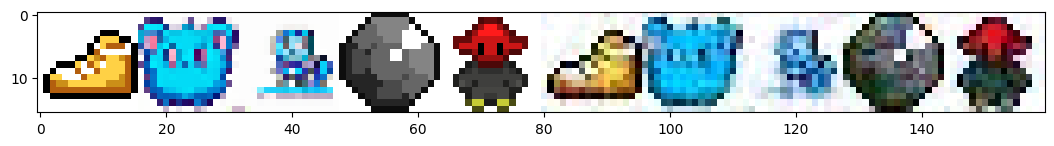

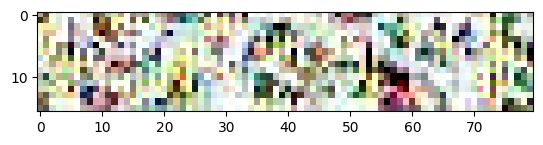

100%|██████████| 2500/2500 [00:25<00:00, 99.40it/s]


Epoch 4/30, Batch 2500/2500, Total Loss: 0.0216, Reconstruction Loss: 0.0112, KL Divergence Loss: 347.3297 Val Loss: 0.0212


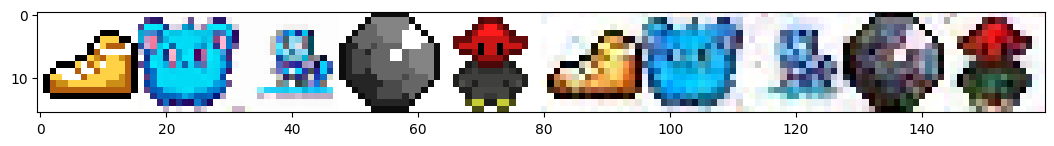

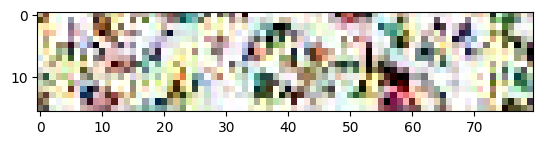

100%|██████████| 2500/2500 [00:24<00:00, 100.25it/s]


Epoch 5/30, Batch 2500/2500, Total Loss: 0.0219, Reconstruction Loss: 0.0114, KL Divergence Loss: 347.7329 Val Loss: 0.0204


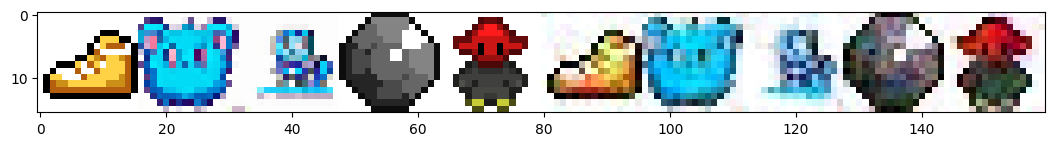

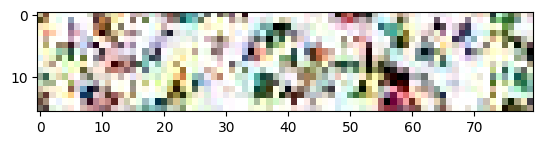

100%|██████████| 2500/2500 [00:24<00:00, 100.58it/s]


Epoch 6/30, Batch 2500/2500, Total Loss: 0.0197, Reconstruction Loss: 0.0095, KL Divergence Loss: 339.4411 Val Loss: 0.0200


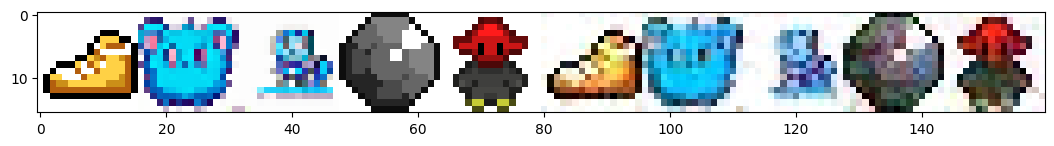

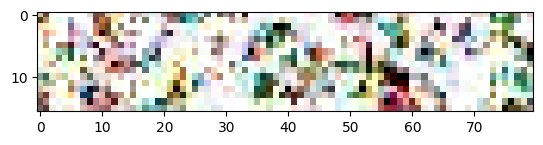

100%|██████████| 2500/2500 [00:24<00:00, 100.99it/s]


Epoch 7/30, Batch 2500/2500, Total Loss: 0.0207, Reconstruction Loss: 0.0107, KL Divergence Loss: 334.0353 Val Loss: 0.0197


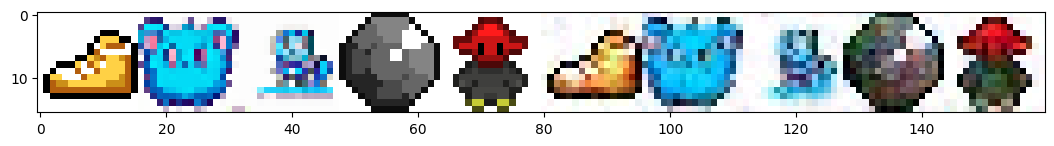

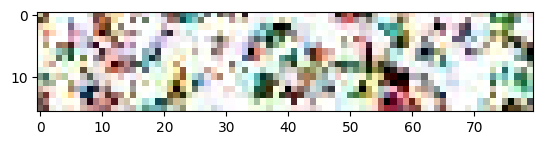

100%|██████████| 2500/2500 [00:24<00:00, 100.22it/s]


Epoch 8/30, Batch 2500/2500, Total Loss: 0.0235, Reconstruction Loss: 0.0133, KL Divergence Loss: 341.5854 Val Loss: 0.0194


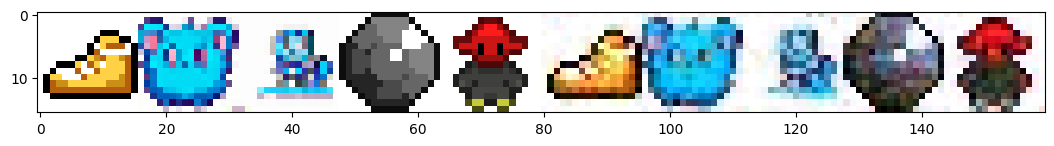

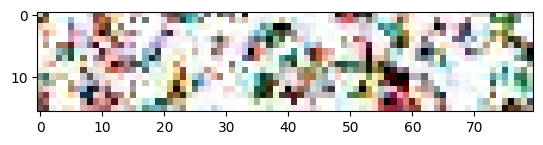

100%|██████████| 2500/2500 [00:25<00:00, 99.75it/s] 


Epoch 9/30, Batch 2500/2500, Total Loss: 0.0209, Reconstruction Loss: 0.0109, KL Divergence Loss: 332.4570 Val Loss: 0.0193


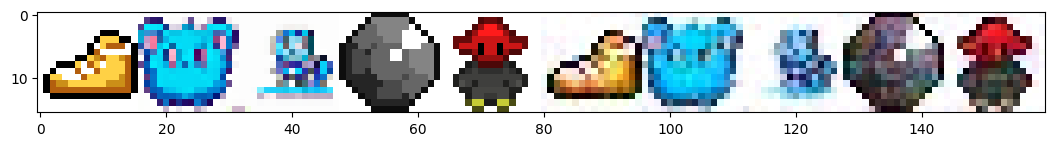

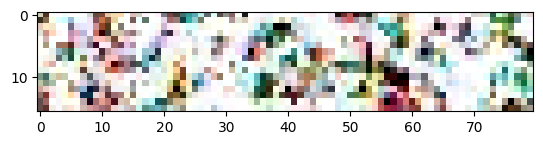

100%|██████████| 2500/2500 [00:25<00:00, 98.06it/s] 


Epoch 10/30, Batch 2500/2500, Total Loss: 0.0184, Reconstruction Loss: 0.0088, KL Divergence Loss: 317.5911 Val Loss: 0.0191


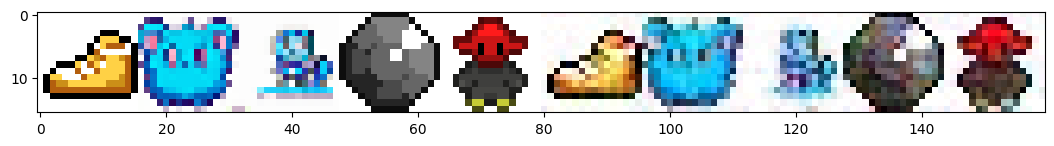

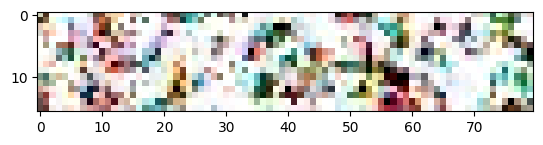

100%|██████████| 2500/2500 [00:25<00:00, 98.66it/s] 


Epoch 11/30, Batch 2500/2500, Total Loss: 0.0213, Reconstruction Loss: 0.0113, KL Divergence Loss: 333.7003 Val Loss: 0.0190


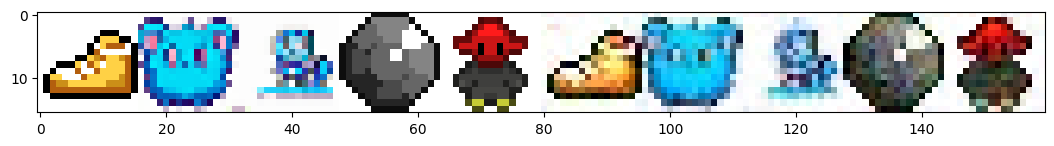

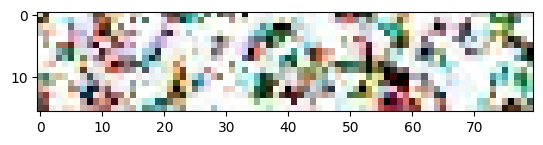

100%|██████████| 2500/2500 [00:25<00:00, 98.59it/s] 


Epoch 12/30, Batch 2500/2500, Total Loss: 0.0203, Reconstruction Loss: 0.0104, KL Divergence Loss: 329.3966 Val Loss: 0.0189


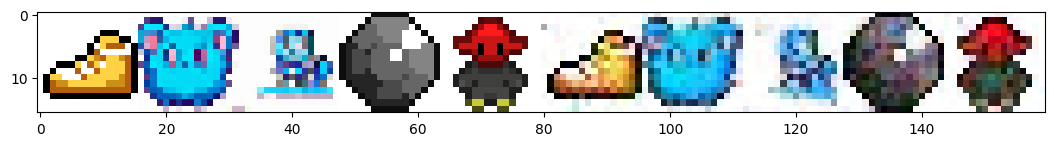

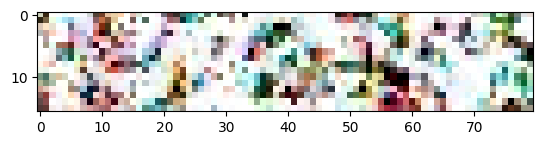

100%|██████████| 2500/2500 [00:25<00:00, 98.16it/s] 


Epoch 13/30, Batch 2500/2500, Total Loss: 0.0210, Reconstruction Loss: 0.0109, KL Divergence Loss: 336.1573 Val Loss: 0.0188


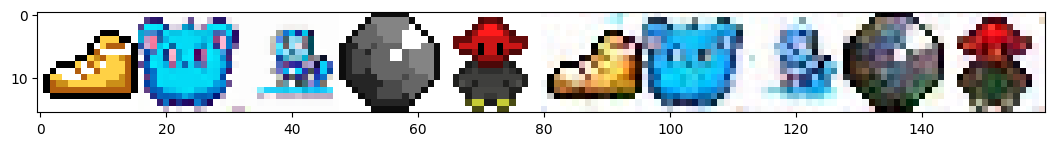

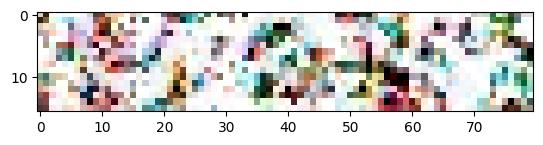

100%|██████████| 2500/2500 [00:25<00:00, 99.40it/s] 


Epoch 14/30, Batch 2500/2500, Total Loss: 0.0197, Reconstruction Loss: 0.0098, KL Divergence Loss: 328.3162 Val Loss: 0.0187


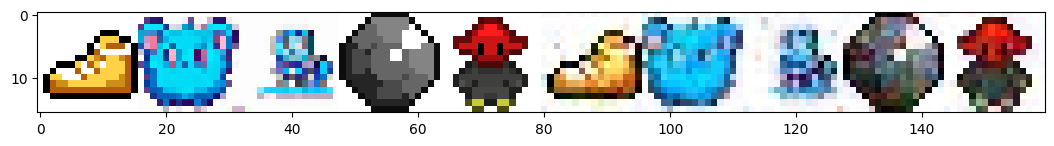

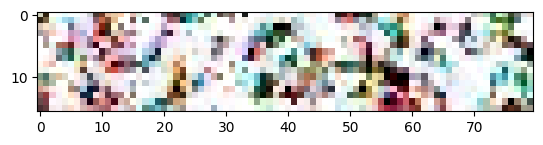

100%|██████████| 2500/2500 [00:25<00:00, 99.36it/s]


Epoch 15/30, Batch 2500/2500, Total Loss: 0.0216, Reconstruction Loss: 0.0116, KL Divergence Loss: 334.2706 Val Loss: 0.0186


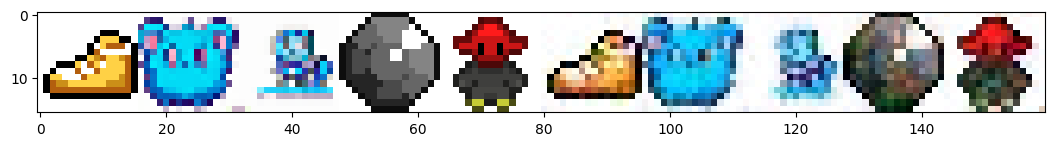

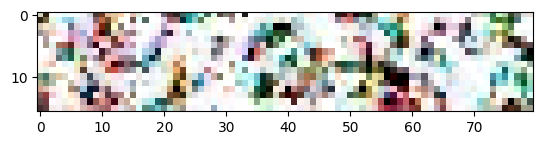

100%|██████████| 2500/2500 [00:25<00:00, 97.69it/s]


Epoch 16/30, Batch 2500/2500, Total Loss: 0.0177, Reconstruction Loss: 0.0080, KL Divergence Loss: 323.2386 Val Loss: 0.0186


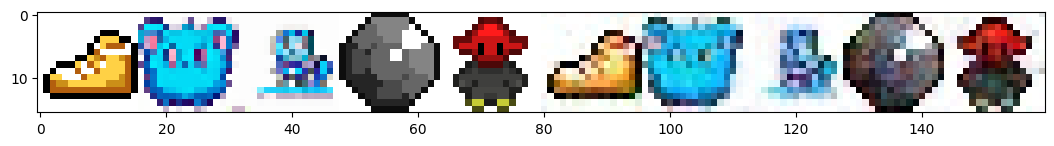

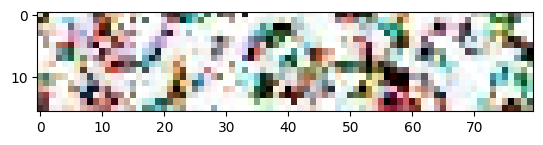

100%|██████████| 2500/2500 [00:25<00:00, 98.60it/s] 


Epoch 17/30, Batch 2500/2500, Total Loss: 0.0198, Reconstruction Loss: 0.0099, KL Divergence Loss: 330.1249 Val Loss: 0.0185


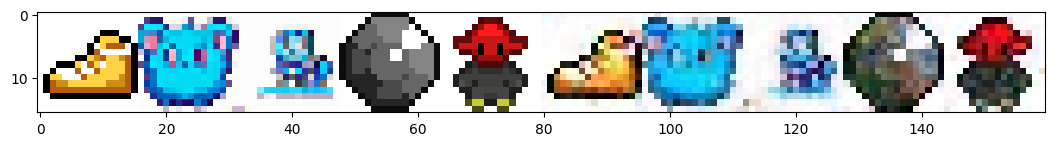

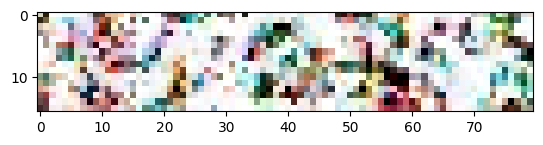

100%|██████████| 2500/2500 [00:25<00:00, 97.84it/s] 


Epoch 18/30, Batch 2500/2500, Total Loss: 0.0199, Reconstruction Loss: 0.0098, KL Divergence Loss: 335.6464 Val Loss: 0.0185


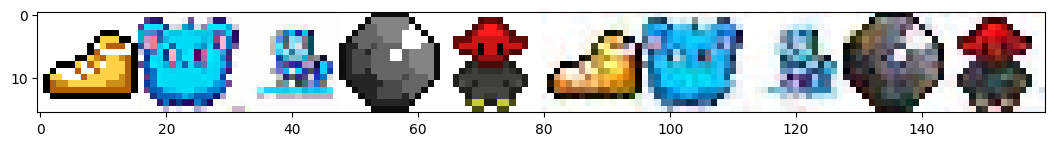

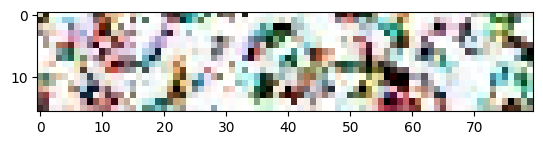

100%|██████████| 2500/2500 [00:25<00:00, 98.64it/s] 


Epoch 19/30, Batch 2500/2500, Total Loss: 0.0185, Reconstruction Loss: 0.0088, KL Divergence Loss: 321.5243 Val Loss: 0.0184


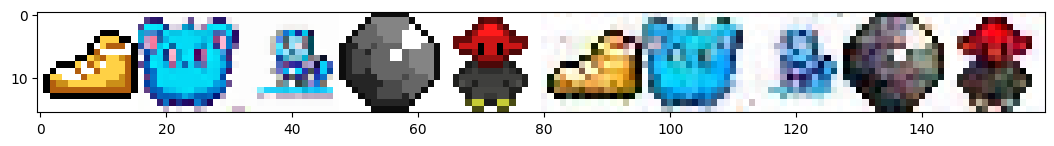

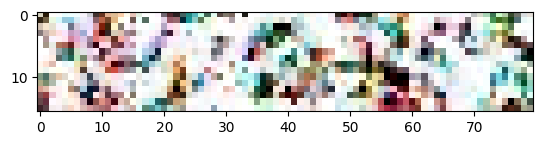

100%|██████████| 2500/2500 [00:25<00:00, 98.38it/s] 


Epoch 20/30, Batch 2500/2500, Total Loss: 0.0191, Reconstruction Loss: 0.0094, KL Divergence Loss: 323.4697 Val Loss: 0.0184


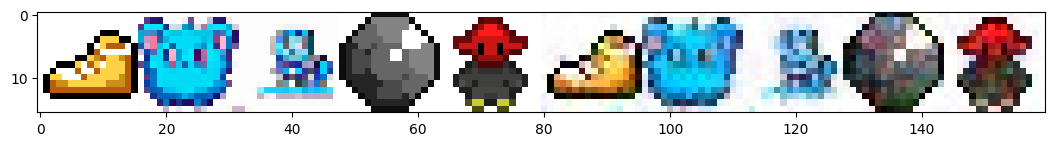

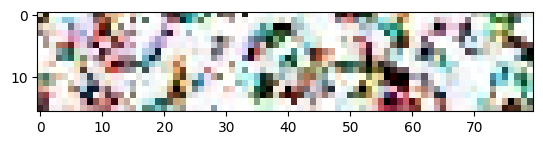

100%|██████████| 2500/2500 [00:25<00:00, 98.62it/s] 


Epoch 21/30, Batch 2500/2500, Total Loss: 0.0196, Reconstruction Loss: 0.0097, KL Divergence Loss: 329.5704 Val Loss: 0.0184


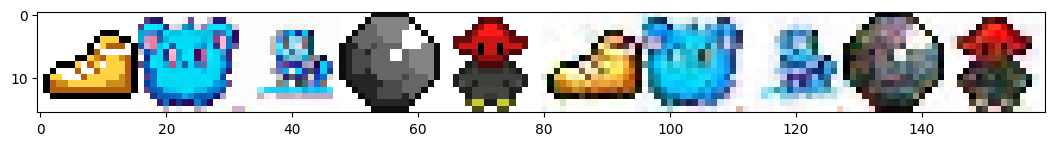

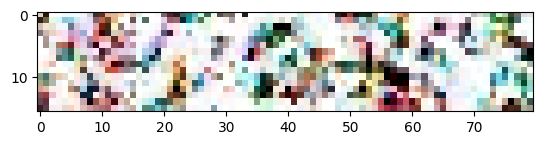

100%|██████████| 2500/2500 [00:25<00:00, 97.62it/s] 


Epoch 22/30, Batch 2500/2500, Total Loss: 0.0198, Reconstruction Loss: 0.0097, KL Divergence Loss: 336.7698 Val Loss: 0.0184


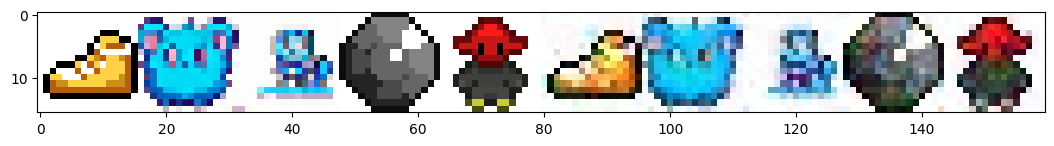

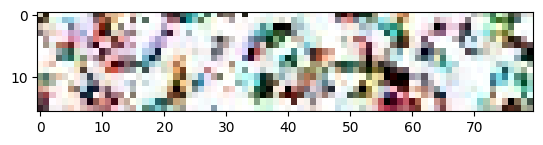

100%|██████████| 2500/2500 [00:26<00:00, 96.01it/s] 


Epoch 23/30, Batch 2500/2500, Total Loss: 0.0178, Reconstruction Loss: 0.0082, KL Divergence Loss: 318.7302 Val Loss: 0.0183


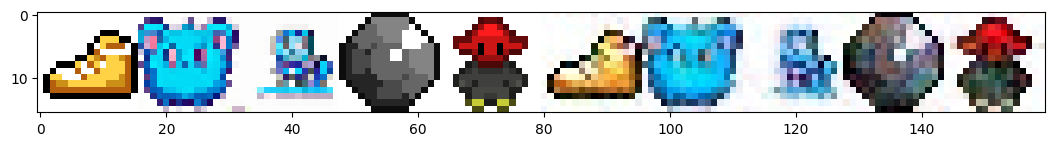

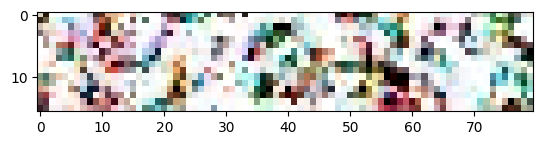

100%|██████████| 2500/2500 [00:25<00:00, 97.53it/s]


Epoch 24/30, Batch 2500/2500, Total Loss: 0.0210, Reconstruction Loss: 0.0109, KL Divergence Loss: 336.6638 Val Loss: 0.0183


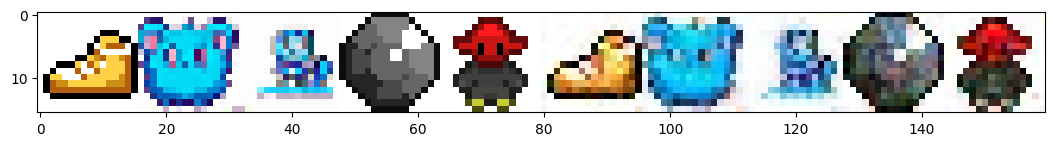

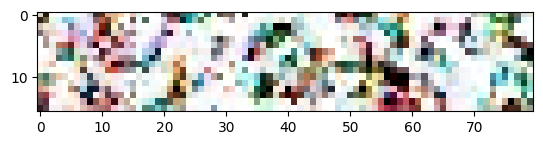

100%|██████████| 2500/2500 [00:25<00:00, 96.92it/s]


Epoch 25/30, Batch 2500/2500, Total Loss: 0.0193, Reconstruction Loss: 0.0096, KL Divergence Loss: 323.1868 Val Loss: 0.0183


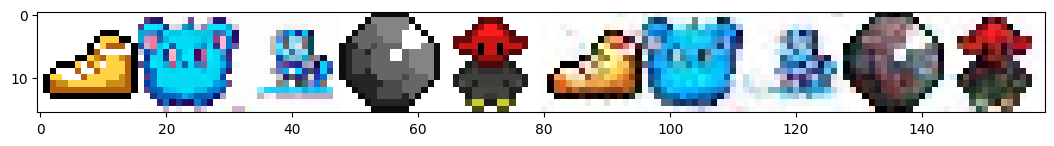

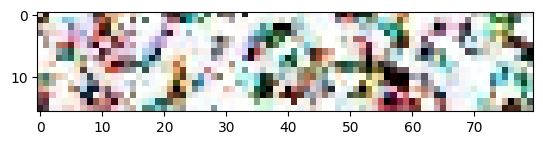

100%|██████████| 2500/2500 [00:25<00:00, 96.80it/s]


Epoch 26/30, Batch 2500/2500, Total Loss: 0.0196, Reconstruction Loss: 0.0098, KL Divergence Loss: 326.9408 Val Loss: 0.0183


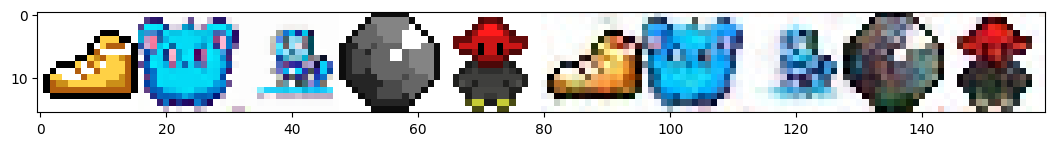

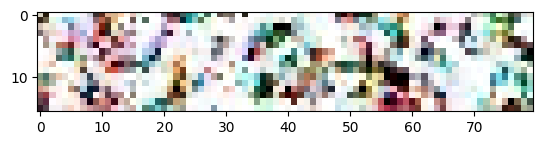

100%|██████████| 2500/2500 [00:25<00:00, 96.71it/s] 


Epoch 27/30, Batch 2500/2500, Total Loss: 0.0191, Reconstruction Loss: 0.0094, KL Divergence Loss: 321.6909 Val Loss: 0.0183


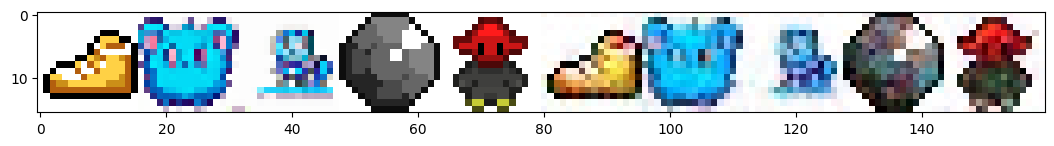

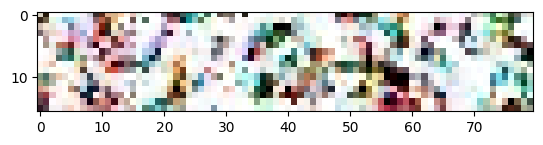

100%|██████████| 2500/2500 [00:25<00:00, 96.38it/s] 


Epoch 28/30, Batch 2500/2500, Total Loss: 0.0178, Reconstruction Loss: 0.0082, KL Divergence Loss: 318.8039 Val Loss: 0.0183


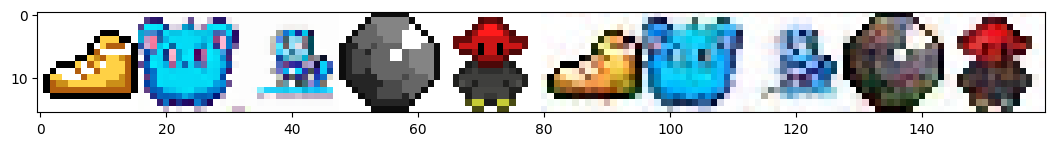

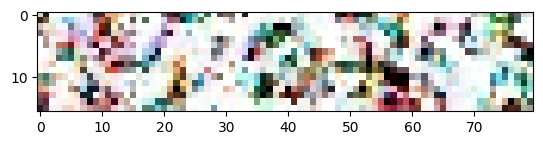

100%|██████████| 2500/2500 [00:26<00:00, 95.85it/s] 


Epoch 29/30, Batch 2500/2500, Total Loss: 0.0204, Reconstruction Loss: 0.0105, KL Divergence Loss: 331.3169 Val Loss: 0.0183


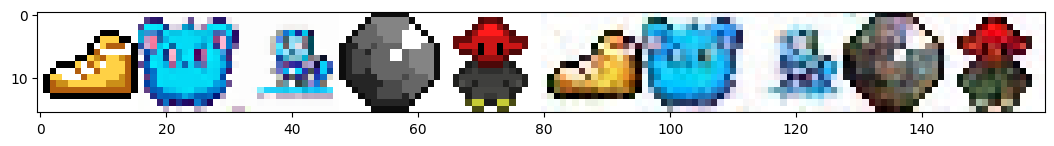

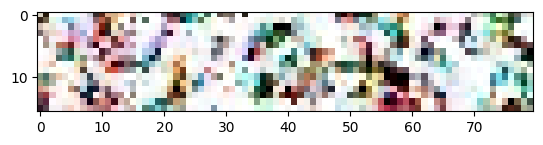

100%|██████████| 2500/2500 [00:25<00:00, 96.37it/s] 


Epoch 30/30, Batch 2500/2500, Total Loss: 0.0183, Reconstruction Loss: 0.0086, KL Divergence Loss: 322.5634 Val Loss: 0.0182


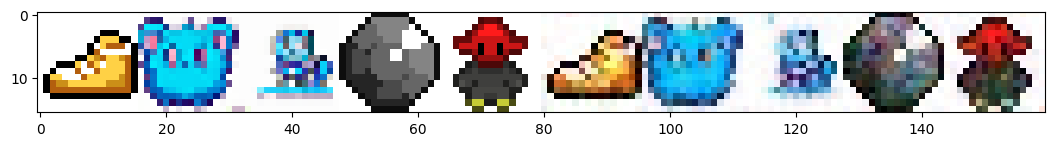

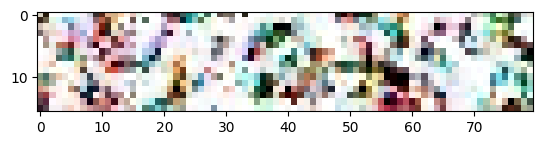

CPU times: user 12min 44s, sys: 12.3 s, total: 12min 57s
Wall time: 13min 10s


In [37]:
%%time

# initialize the best validation loss as infinity
best_val_loss = float("inf")
print("Training Started!!")

model = model.to(DEVICE)
x_test = x_test.to(DEVICE)

random_noise = torch.randn((5, EMBEDDING_DIM, 8, 8)).to(DEVICE)

# start training by looping over the number of epochs
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for i, x in enumerate(tqdm(train_loader)):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        predictions = model(x)
        total_loss = loss_function(predictions, KLD_WEIGHT)

        # Backward pass
        total_loss["loss"].backward()

        # Optimizer variable updates
        optimizer.step()

        running_loss += total_loss["loss"].item()

    # compute average loss for the epoch
    train_loss = running_loss / len(train_loader)

    # compute validation loss for the epoch
    val_loss = validate(model, valid_loader, DEVICE)

    # save best vae model weights based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({"vae": model.state_dict()}, MODEL_BEST_WEIGHTS_PATH)

    torch.save({"vae": model.state_dict()}, MODEL_WEIGHTS_PATH)

    print(
        f"Epoch {epoch+1}/{EPOCHS}, Batch {i+1}/{len(train_loader)}, "
        f"Total Loss: {total_loss['loss'].detach().item():.4f}, "
        f"Reconstruction Loss: {total_loss['Reconstruction_Loss']:.4f}, "
        f"KL Divergence Loss: {total_loss['KLD']:.4f}",
        f"Val Loss: {val_loss:.4f}",
    )

    if 1: # epoch % 5 == 0:
        model.eval()
        predictions = model(x_test)
        fig = plt.figure(figsize=(13,5))
        plt.imshow(torch.cat([x_test, predictions[0]]).permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
        plt.show()

        # 랜덤 노이즈에 대한 생성
        x_recon = model.decode(random_noise)
        plt.imshow(x_recon.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
        plt.show()

    scheduler.step()

### 모델 불러오기

In [46]:
# model load
# MODEL_BEST_WEIGHTS_PATH
# 저장된 모델 상태를 불러옵니다.
model_state = torch.load(MODEL_BEST_WEIGHTS_PATH, weights_only=True)

# 모델 상태를 현재 모델에 로드합니다.
model.load_state_dict(model_state['vae'])
model.eval();

### 샘플 재구성

- 학습에서 사용한 `x_test`에 대해서 인코딩, 디코딩

In [47]:
mu, log_var = model.encode(x_test)
z = model.reparameterize(mu, log_var)
x_recon = model.decode(z)

x_test.shape, z.shape, x_recon.shape

(torch.Size([5, 3, 16, 16]),
 torch.Size([5, 5, 8, 8]),
 torch.Size([5, 3, 16, 16]))

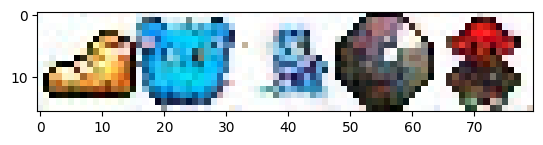

In [48]:
plt.imshow(x_recon.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

### 잠재변수(노이즈)로 부터 재구성

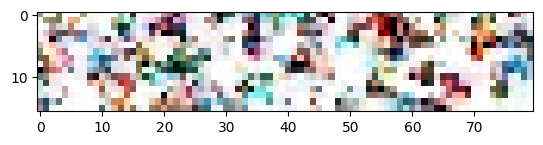

In [49]:
random_noise = torch.randn_like(z)

x_recon = model.decode(random_noise)
plt.imshow(x_recon.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()
